
# Data Preparation

## Imports

In [1]:
    from os import listdir
import os.path
from os.path import isfile, join
from osgeo import gdal
import numpy as np

In [2]:
path_labels = os.getcwd() + "/1_labeled_data/tif/"

path_rdg = "/home/jovyan/work/satellite_data/"
label_tif = path_labels + "22-01-05.TIF"

print(os.path.isfile(path_rdg + "2629BD_2018.tif"), os.path.isfile(label_tif))
# TODO: locally only jp2.tif files, whereas on the server only tif file?!

True True


In [3]:
def print_files(path = os.getcwd()):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    print(path, onlyfiles)
print_files(path_labels)

/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/ ['22-01-05-uploaded.tif', '22-01-05.TIF', 'check-labels-jp2-capizalized-22-01-05.TIF', 'labels-jp2-tif-22.01-05.tif', '22-01-05-test-3-without-tif.tif', 'now.tif', '22-01-30.tif', '22-01-06-with-tif.tif']


###### Import Image with GDAL

In [4]:
dataset = gdal.Open(path_rdg + "2629BD_2018.tif")
# "/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/144.tif" (label file) results in an error -> probably wrong format?

### 0.1 Data Inspection

In [5]:
# General Dataset Information
def inspect_tif(dataset):
    print("1. General TIF Data:")
    print("Metadata:", dataset.GetMetadata())
    print("Type Image: ", type(dataset))
    print("Projection: ", dataset.GetProjection())
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
    print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    print("2. Raster Band:")
    print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(min,max))

    if band.GetOverviewCount() > 0:
        print("Band has {} overviews".format(band.GetOverviewCount()))

    if band.GetRasterColorTable():
        print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[1])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    print("""Image Size: 
        # Pixels in Image = ({}, {})
        Size of one Pixel in cm = {}
        Size Covered by Image / Image Size = ({}m, {}m)""".format(size_x_px, size_y_px, 
                                                                                    tuple([100*x for x in pixel_size]),
                                                                                    size_x, size_y)
    )
inspect_tif(dataset)

1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 3
Driver: GTiff/GeoTIFF
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=255.000
Band has 8 overviews
Image Size: 
        # Pixels in Image = (108224, 107798)
        Size of one Pixel in cm = (0.0002372814

In [6]:
some_dataset = gdal.Open(path_rdg + "2627DC_2018.tif")
inspect_tif(some_dataset)

1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 107608 x 107249 x 3
Driver: GTiff/GeoTIFF
Origin = (27.497387693796565, -26.74753635381557)
Pixel Size = (2.3770193857792506e-06, -2.3770193857792447e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=240.000
Band has 8 overviews
Image Size: 
        # Pixels in Image = (107608, 107249)
        Size of one Pixel in cm = (0.00023770193

In [7]:
# optional conversion to np array
# channel = np.array(dataset.GetRasterBand(1).ReadAsArray())
# print(channel.shape)

In [8]:
# Read the raster band as separate variable
#band = dataset.GetRasterBand(1)

# Check type of the variable 'band'
#type(band)

# Data type of the values
#gdal.GetDataTypeName(band.DataType)

In [9]:
import matplotlib.pyplot as plt
#print(dataset.RasterCount)
#print(labels.RasterCount, labels.RasterXSize, labels.RasterYSize)
print(dataset.RasterCount, dataset.RasterXSize, dataset.RasterYSize)

3 108224 107798


In [10]:
# band1 = labels.GetRasterBand(1) # Red channel
# band2 = labels.GetRasterBand(2) # Green channel
# band3 = labels.GetRasterBand(3) # Blue channel

In [11]:
#labels.GetRasterBand()

### 0.2 Load Labels

In [12]:
def load_tif(tif_filepath):
    if not os.path.isfile(tif_filepath):
        print("Filepath exists:", os.path.isfile(tif_filepath)) 
    else:
        labeled_data = gdal.Open(tif_filepath)
        if labeled_data:
            print("0 Success", tif_filepath)
            inspect_tif(labeled_data)
        else: print("1 Failure", tif_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

In [13]:
labels = path_labels + "22-01-05.TIF"

In [14]:
load_tif(labels)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/22-01-05.TIF
1. General TIF Data:
Metadata: {'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  
Size is 20335 x 20255 x 4
Driver: GTiff/GeoTIFF
Origin = (0.0, 0.0)
Pixel Size = (1.0, 1.0)
2. Raster Band:
Band Type=Byte
Min=255.000, Max=255.000
Image Size: 
        # Pixels in Image = (20335, 20255)
        Size of one Pixel in cm = (100.0, 100.0)
        Size Covered by Image / Image Size = (20335.0m, 20255.0m)


In [15]:
#check if all (label) files in a directory are loadable
def check_all_labels(directory = os.fsencode(path_labels)):
    print("Labels")    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".tif") or filename.endswith(".TIF") or filename.endswith(".tiff"): 
            print(filename)
            load_tif(path_labels + filename)
            print("")
            continue
        else:
            continue
#check_all_labels(os.fsencode(path_labels))

In [16]:
# extract logic from load_tif function
# load_tif(path_labels + "labels-jp2-tif-22.01-05.tif")
tif_filepath = path_labels + "labels-jp2-tif-22.01-05.tif"
if not os.path.isfile(tif_filepath):
        print("Filepath exists:", os.path.isfile(tif_filepath)) 
else:
    labeled_data = gdal.Open(tif_filepath)
    if labeled_data:
        print("0 Success", tif_filepath)
        inspect_tif(labeled_data)
    else: print("1 Failure", tif_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/labels-jp2-tif-22.01-05.tif
1. General TIF Data:
Metadata: {'AREA_OR_POINT': 'Area', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 24119 x 24024 x 4
Driver: GTiff/GeoTIFF
Origin = (29.7468774418073, -26.247113163)
Pixel Size = (1.0647046162171074e-05, -1.0647046162171074e-05)
2. Raster Band:
Band Type=Byte
Min=255.000, Max=255.000
Image Size: 
        # Pixels in Image = (24119, 24024)
        Size of one Pixel in cm = (0.0010647046162171074, 0.0010647046162171074)
        Size Covered by Image / Image 

In [17]:
# 0 Success exported.TIF                       --                                                      -- labels with hidden raster dimension
# 0 Success exported.tiff                      -- maybe can't read .tiff                               -- labels with hidden raster dimension
# 1 Failure exported.tif                       -- 
# 0 Success exported_in_caps.TIF               -- Something exported dirctly with TIF as fileextension -- labels with hidden raster dimension
# 1 Failure labels-22-01-05.TIF                -- label exported and renamed into TIF fileextension
# 0 Success exported_tif.tif                   -- only tif file exported
# 1 Failure labels-22-01-05-only-polygon.TIF
# os.getcwd()

### 0.3 Preview labels (TIF)

In [18]:
import rasterio
from rasterio.plot import show
# label = rasterio.open(tif_filepath)
# show(label)

In [19]:
# No. of Bands, Image resolution (X, Y), CRS (Coordinate Reference System)
# print(label.count, label.height, label.width, label.crs)

In [20]:
def preview_tif(tif_filepath):
    if os.path.isfile(tif_filepath):
        img = rasterio.open(tif_filepath)
        show(img)
    else: print("File does not exist.")

In [21]:
example_tif = path_rdg + "2629BD_2018.tif"
# preview_tif(example_tif)

### 0.4 Crop TIF

In [22]:
load_tif(example_tif)

0 Success /home/jovyan/work/satellite_data/2629BD_2018.tif
1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 3
Driver: GTiff/GeoTIFF
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=255.000
Band has 8 overviews
Image Size: 
        # Pixels in Image = (1082

In [23]:
print("$ gdalinfo '/home/jovyan/work/satellite_data/2629BD_2018.tif'")
print("""Corner Coordinates:
Upper Left  (  29.7468778, -26.2471132) ( 29d44'48.76"E, 26d14'49.61"S)
Lower Left  (  29.7468778, -26.5028978) ( 29d44'48.76"E, 26d30'10.43"S)
Upper Right (  30.0036732, -26.2471132) ( 30d 0'13.22"E, 26d14'49.61"S)
Lower Right (  30.0036732, -26.5028978) ( 30d 0'13.22"E, 26d30'10.43"S)
Center      (  29.8752755, -26.3750055) ( 29d52'30.99"E, 26d22'30.02"S)""")

$ gdalinfo '/home/jovyan/work/satellite_data/2629BD_2018.tif'
Corner Coordinates:
Upper Left  (  29.7468778, -26.2471132) ( 29d44'48.76"E, 26d14'49.61"S)
Lower Left  (  29.7468778, -26.5028978) ( 29d44'48.76"E, 26d30'10.43"S)
Upper Right (  30.0036732, -26.2471132) ( 30d 0'13.22"E, 26d14'49.61"S)
Lower Right (  30.0036732, -26.5028978) ( 30d 0'13.22"E, 26d30'10.43"S)
Center      (  29.8752755, -26.3750055) ( 29d52'30.99"E, 26d22'30.02"S)


In [24]:
upper_left_x = 29.746877767434313
upper_left_y = -26.247113163017453
lower_right_x = 30.0036732
lower_right_y = -26.5028978

# adjust cutout -> 1/100 size in top left corner
lower_right_x = upper_left_x + (lower_right_x - upper_left_x)/10
lower_right_y = upper_left_y + (lower_right_y - upper_left_y)/10

print(upper_left_x, upper_left_y, lower_right_x, lower_right_y)

29.746877767434313 -26.247113163017453 29.772557310690882 -26.27269162671571


In [25]:
cropped_window = (upper_left_x,upper_left_y,lower_right_x,lower_right_y) #(upper_left_x,upper_left_y,lower_right_x,lower_right_y)
cropped_raster = os.getcwd()+'/2_cutouts/cropped_raster.tif'
gdal.Translate(cropped_raster, example_tif, projWin = cropped_window)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fcfcdac1870> >

In [26]:
load_tif(cropped_raster)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/cropped_raster.tif
1. General TIF Data:
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 10822 x 10780 x 3
Driver: GTiff/GeoTIFF
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
2. Raster Band:
Band Type=Byte
Min=0.000, Max=224.000
Image Size: 
        # P

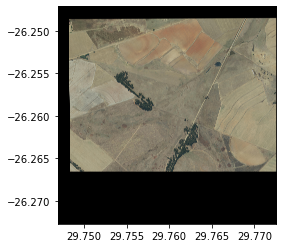

In [27]:
preview_tif(cropped_raster)

In [28]:
path_labels

'/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/'

In [29]:
checkpoint_labels = path_labels + "22-01-05-uploaded.tif"
load_tif(checkpoint_labels)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/22-01-05-uploaded.tif
1. General TIF Data:
Metadata: {'AREA_OR_POINT': 'Area', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 1291 x 1286 x 4
Driver: GTiff/GeoTIFF
Origin = (29.746877767, -26.247105033623935)
Pixel Size = (0.00019891204957397287, -0.00019891204957397287)
2. Raster Band:
Band Type=Byte
Min=52.000, Max=255.000
Image Size: 
        # Pixels in Image = (1291, 1286)
        Size of one Pixel in cm = (0.019891204957397286, 0.019891204957397286)
        Size Covered by Image / Image Size = (0.2

In [30]:
checkpoint_labels_now = path_labels + "22-01-05-test-3-without-tif.tif"
load_tif(checkpoint_labels_now)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/22-01-05-test-3-without-tif.tif
1. General TIF Data:
Metadata: {'AREA_OR_POINT': 'Area', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 3851 x 10655 x 4
Driver: GTiff/GeoTIFF
Origin = (29.748224258, -26.248664720720466)
Pixel Size = (1.674316307452562e-05, -1.674316307452562e-05)
2. Raster Band:
Band Type=Byte
Min=56.000, Max=255.000
Image Size: 
        # Pixels in Image = (3851, 10655)
        Size of one Pixel in cm = (0.001674316307452562, 0.001674316307452562)
        Size Covered by Image / Image S

In [31]:
checkpoint_labels_now = path_labels + "now.tif"
load_tif(checkpoint_labels_now)

0 Success /home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/now.tif
1. General TIF Data:
Metadata: {'AREA_OR_POINT': 'Area', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_XRESOLUTION': '72', 'TIFFTAG_YRESOLUTION': '72'}
Type Image:  <class 'osgeo.gdal.Dataset'>
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 11087 x 11043 x 4
Driver: GTiff/GeoTIFF
Origin = (29.746873599209952, -26.247113163)
Pixel Size = (2.3162604093090454e-05, -2.3162604093090454e-05)
2. Raster Band:
Band Type=Byte
Min=100.000, Max=255.000
Image Size: 
        # Pixels in Image = (11087, 11043)
        Size of one Pixel in cm = (0.0023162604093090455, 0.0023162604093090455)
        Size Covered by Image / Image Size = (0.25680379

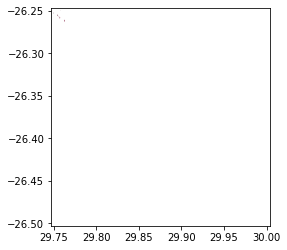

In [32]:
preview_tif(checkpoint_labels_now)

In [33]:
# close tif
#dataset = None